In [7]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from DLC_for_WBFM.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fname = "/scratch/zimmer/Charles/dlc_stacks/worm3-newseg-2021_11_17/project_config.yaml"
project_data = ProjectData.load_final_project_data_from_config(fname)

Project data for directory:
/scratch/zimmer/Charles/dlc_stacks/worm3-newseg-2021_11_17 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: True
============Tracklets==================
df_training_tracklets: True
reindexed_masks_training: True
============Traces=====================
red_traces: True
green_traces: True
final_tracks: True
behavior_annotations: True



In [3]:
all_tracklets = project_data.df_all_tracklets

In [5]:
# all_matches = project_data.raw_matches

In [11]:
track_cfg = project_data.project_config.get_tracking_config()
fname = track_cfg.resolve_relative_path_from_config('final_3d_tracks_df')

df_tracks = pd.read_hdf(fname)
df_tracks.replace(0.0, np.nan, inplace=True)

In [26]:
# From different project, but same templates
fname = "/scratch/zimmer/Charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/postprocessing/leifer_tracks.h5"
df_leifer = pd.read_hdf(fname)
df_leifer.replace(0.0, np.nan, inplace=True)

# Look at a tracklet with known splitting

In [31]:
# Of course leifer splits too, but we know approximately what is correct

candidate1 = 'neuron_001'
candidate2 = 'neuron_044'

tracklet_candidate = 'neuron3864'

split_point = (473, 474)

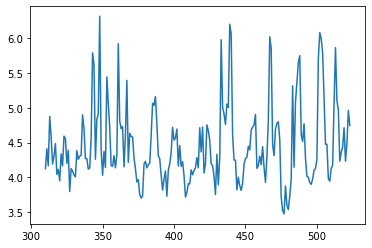

In [15]:
this_tracklet = all_tracklets[tracklet_candidate]
this_tracklet['z'].plot()

In [27]:
t1 = df_leifer[candidate1]
t2 = df_leifer[candidate2]

In [28]:
def calc_all_dist(df1, df2):
    # Check if they are same neuron, i.e. right on top of each other
    df1.replace(0.0, np.nan, inplace=True)
    df2.replace(0.0, np.nan, inplace=True)
    df_norm = np.sqrt(np.square(df1 - df2).sum(axis=1, min_count=1))
    
    num_total1 = df1.count()[0]
    num_total2 = df2.count()[0]
    num_total_total = df_norm.count()

    return df_norm.to_numpy(), num_total1, num_total2, num_total_total

In [29]:
d1 = calc_all_dist(this_tracklet, t1)[0]
d2 = calc_all_dist(this_tracklet, t2)[0]

Text(0.5, 1.0, 'Distance between a tracklet with a known jump and leifer candidates')

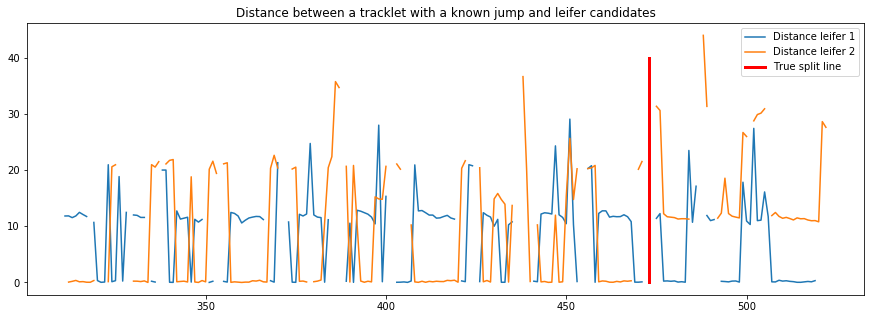

In [45]:
plt.figure(figsize=(15,5))
plt.plot(d1, label="Distance leifer 1")
plt.plot(d2, label="Distance leifer 2")
plt.plot([split_point[0], split_point[0]], [0, 40], 'r', lw=3, label="True split line")
plt.legend()
plt.title("Distance between a tracklet with a known jump and leifer candidates")

Text(0.5, 1.0, 'Distance between a tracklet with a known jump and leifer candidates')

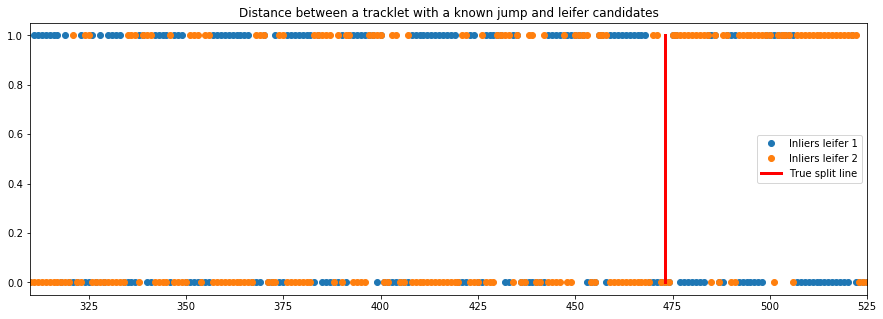

In [50]:
tol = 1.0

plt.figure(figsize=(15,5))
plt.plot(d1 > tol, 'o', label="Inliers leifer 1")
plt.plot(d2 > tol, 'o', label="Inliers leifer 2")
plt.plot([split_point[0], split_point[0]], [0, 1], 'r', lw=3, label="True split line")
plt.xlim([310, 525])
plt.legend()

plt.title("Distance between a tracklet with a known jump and leifer candidates")

In [51]:
import ruptures as rpt


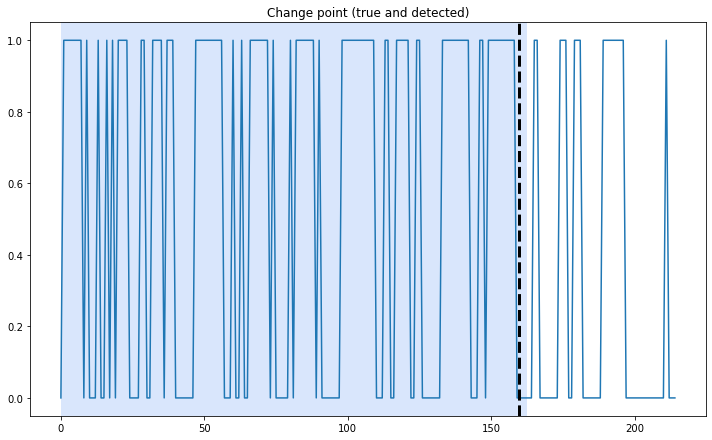

In [68]:
signal = d1[310:525] > tol
true_bkps = [split_point[0] - 310]

model = "l2"  # "l1", "rbf", "linear", "normal", "ar",...
algo = rpt.Binseg(model=model).fit(signal)
my_bkps = algo.predict(n_bkps=1)


rpt.show.display(signal, true_bkps, my_bkps, figsize=(10, 6))
plt.title("Change point (true and detected)")
plt.show()

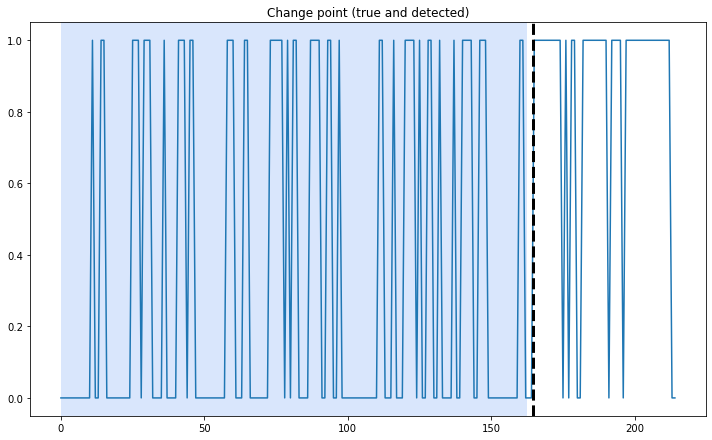

In [69]:
signal = d2[310:525] > tol
true_bkps = [split_point[0] - 310]

model = "l2"  # "l1", "rbf", "linear", "normal", "ar",...
algo = rpt.Binseg(model=model).fit(signal)
my_bkps = algo.predict(n_bkps=1)


rpt.show.display(signal, true_bkps, my_bkps, figsize=(10, 6))
plt.title("Change point (true and detected)")
plt.show()

In [72]:
algo.single_bkp(0, 250)

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/ruptures/costs/costl2.py:52: RuntimeWarning: Degrees of freedom <= 0 for slice
  return self.signal[start:end].var(axis=0).sum() * (end - start)
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


(165, 13.593958929478669)